In [1]:
import os
import pickle

import torch
import geoopt

import networkx as nx
import numpy as np
import pandas as pd

from utils import data

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data_path = "./data"
tissue_hierarchy, ppi_networks, labels = data.read_data(data_path)
leaf_tissues = [node for node in tissue_hierarchy.nodes() if tissue_hierarchy.out_degree()[node]==0]
internal_tissues = [node for node in list(reversed(list(nx.topological_sort(tissue_hierarchy)))) if node not in leaf_tissues]

config = {
    "manifold": None,
    "embedding_dim": 128,

    "p": 1,
    "q": 4,                   
    "walks_per_node": 1,
    "walk_length": 10,
    "context_size": 10,
    "num_negative_samples": 1,
 
    "num_epochs": 100,
    "test_epochs": 5,
    "batch_size": 64,          
    "learning_rate": 0.025,    
    "lambda": 0.2,              
  
    "device": torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0"),
    "num_workers": 16 if not torch.cuda.is_available() else 0
}

epochs = np.arange(0, config["num_epochs"] + 1, config["test_epochs"])

result_path = "./results"
results = dict()

for manifold in ["Euclidean", "Lorentz"]:
    results[manifold] = dict()

    config["manifold"] = geoopt.manifolds.Lorentz(k = 1.0, learnable = False) if manifold == "Lorentz" else None
    config_name = '_'.join(key + str(val).replace(".", "").replace(':', '').split(" ")[0] for key, val in config.items())
    model_path = os.path.join(result_path, config_name)

    for tissue_name in tissue_hierarchy.nodes():
        model_results_path = os.path.join(model_path, tissue_name + "_results.pickle")
        if os.path.exists(model_results_path):
            with open(model_results_path, 'rb') as f:
                results[manifold][tissue_name] = pickle.load(f)

Read data:
	Tissue hierarchy with 219 nodes.
	144 tissue-specific PPI networks, with an average of 1906.99 nodes and 25462.24 edges.
	503 tissue-specific cellular functions (with 420 unique functions) covering 48 distinct tissues.


In [3]:
df_results = pd.DataFrame(columns = ["Manifold", "Tissue", "Tissue type", "Task", "Metric", "Epoch", "value"])
for manifold, manifold_dict in results.items():
    for tissue, tissue_dict in manifold_dict.items():

        if tissue in leaf_tissues:
            tissue_type = "Leaf"
        else: 
            tissue_type = "Internal"

        if "node_classification" in tissue_dict:
            for function, function_dict in tissue_dict["node_classification"].items():
                for metric in ["local AUROC", "local AUPR", "global AUROC", "global AUPR"]:
                    for i, splits in enumerate(function_dict[metric]):
                        for split_result in splits:
                            df_results.loc[len(df_results.index)] = [manifold, tissue, tissue_type, function, metric, epochs[i], split_result]

        if "embedding_distortion" in tissue_dict:
            for i, distortion in enumerate(tissue_dict["embedding_distortion"]):
                df_results.loc[len(df_results.index)] = [manifold, tissue, tissue_type, "distortion", "DIST", epochs[i], distortion]

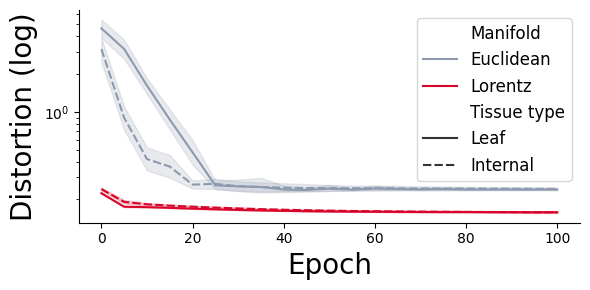

In [11]:
plt.figure(figsize=(6, 3))
ax = plt.gca()

sns.lineplot(data = df_results[(df_results["Metric"] == "DIST")],
            x = "Epoch", y = "value", hue = "Manifold", style = "Tissue type", palette = {"Euclidean" : "#8d99ae", "Lorentz": "#d90429"}, ax=ax)

ax.spines[['top', 'right']].set_visible(False)
#ax.set_title("Graph distortion", fontsize=20)
ax.legend(fontsize="12", loc ="upper right")
ax.set_xlabel("Epoch", fontsize=20)
ax.set_ylabel("Distortion (log)", fontsize=20)
ax.set_yscale("log")

plt.tight_layout()
plt.savefig('results/FigRes1.png', dpi = 600)
plt.show()

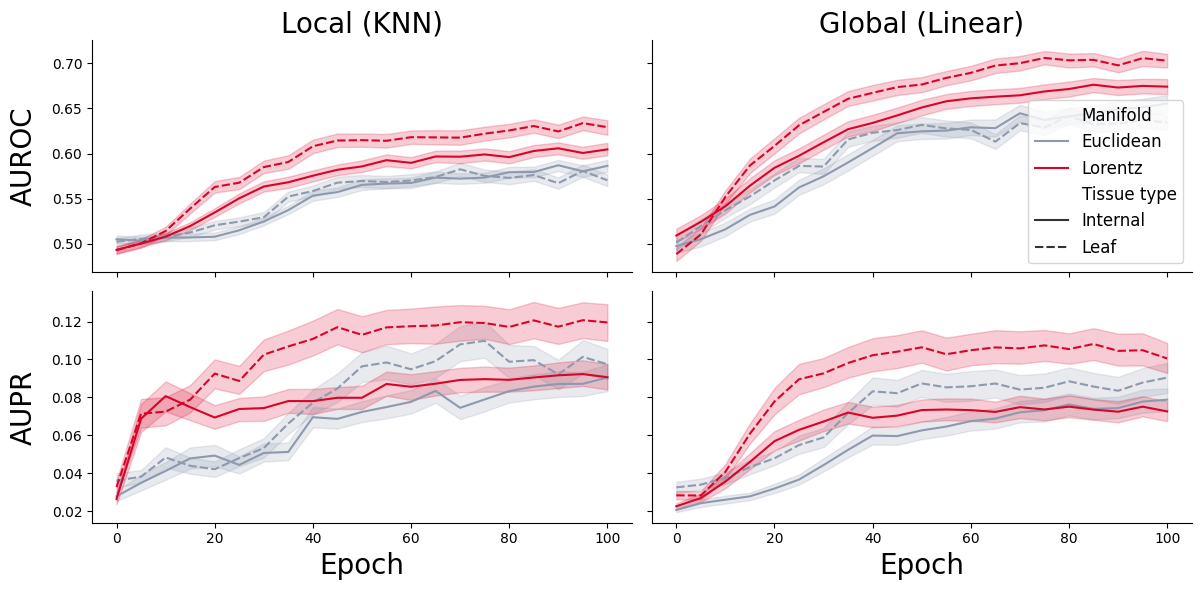

In [12]:
metrics = ["local AUROC", "global AUROC", "local AUPR", "global AUPR"]

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey="row", sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]

    sns.lineplot(data = df_results[(df_results["Metric"] == metric)],
                x = "Epoch", y = "value", hue = "Manifold", style = "Tissue type", palette = {"Euclidean" : "#8d99ae", "Lorentz": "#d90429"}, ax=ax)
    
    ax.spines[['top', 'right']].set_visible(False)

    if i == 1:
        ax.legend(fontsize="12", loc ="lower right")
    else:
        ax.get_legend().remove()

    if i == 0:
        ax.set_title("Local (KNN)", fontsize=20)
    elif i == 1:
        ax.set_title("Global (Linear)", fontsize=20)
     
    if i // 2 == 1:
        ax.set_xlabel("Epoch", fontsize=20)
    else:
        ax.set_xlabel("")

    if i % 2 == 0:
        ax.set_ylabel(metric.split(" ")[1], fontsize=20)
        ax.yaxis.set_label_coords(-0.1, 0.5)
    else:
        ax.set_ylabel("")
    
plt.tight_layout()
plt.savefig('results/FigRes2.png', dpi = 600)
plt.show()

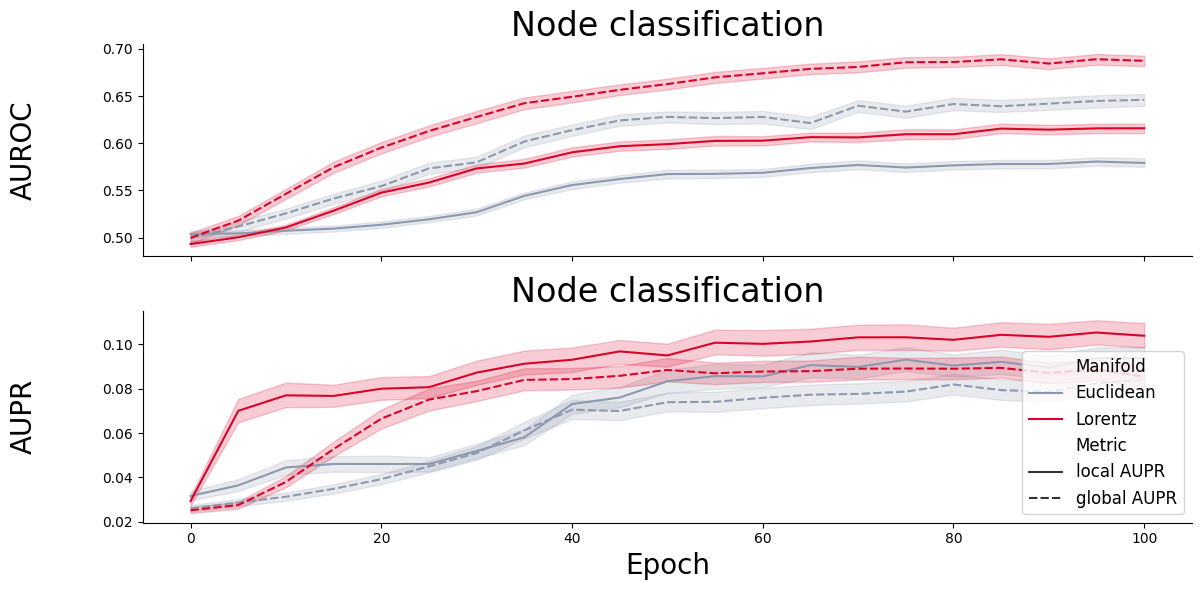

In [13]:
metrics = ["AUROC", "AUPR"]

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]

    sns.lineplot(data = df_results[(df_results["Metric"] == "local " + metric) | (df_results["Metric"] == "global " + metric)],
                x = "Epoch", y = "value", hue = "Manifold", style = "Metric", palette = {"Euclidean" : "#8d99ae", "Lorentz": "#d90429"}, ax=ax)
    
    ax.spines[['top', 'right']].set_visible(False)

    ax.set_title("Node classification", fontsize=24)
     
    ax.set_ylabel(metric, fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    if i == 1:
        ax.legend(fontsize="12", loc ="lower right")
        ax.set_xlabel("Epoch", fontsize=20)
    else:
        ax.get_legend().remove()
        ax.set_xlabel("")

plt.tight_layout()
plt.show()